# Superconduct dataset - linear regression

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, SGD_Descent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.data.RealDatasetPreparation import prepare_superconduct
from src.utils.Constants import *
from src.utils.data.DataClustering import *
from src.utils.data.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "superconduct-gamma-limit"

nb_devices_for_the_run = 20

# Handling non-iid data

No missing value. Great !
Scaling data.
There is 81 dimensions.
Head of the dataset:
   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0           -0.080058          0.046733             -0.451651   
1            0.614744          0.174269             -0.432071   
2           -0.080058          0.046733             -0.450978   
3           -0.080058          0.046733             -0.451314   
4           -0.080058          0.046733             -0.452324   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          -0.158850              -0.611819             0.044358   
1           0.059368              -0.604180             0.777430   
2          -0.158850              -0.611658             0.044358   
3          -0.158850              -0.611739             0.044358   
4          -0.158850              -0.611980             0.044358   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                -0.003707           0.1337

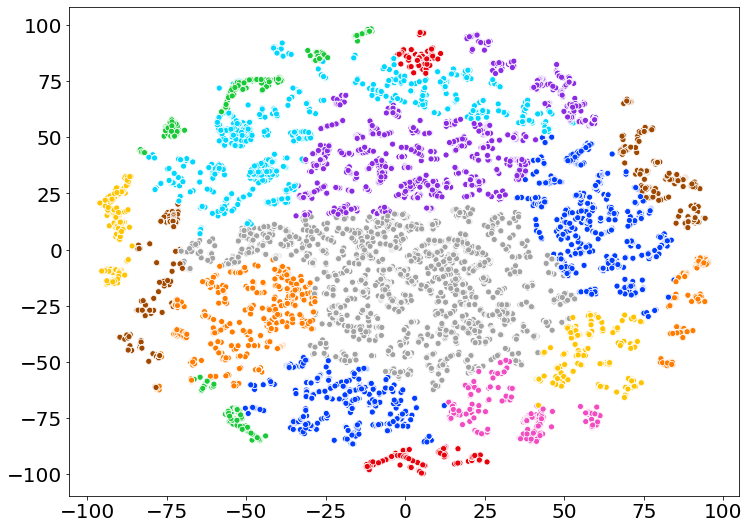

In [2]:
%%time
X, Y, dim_notebook = prepare_superconduct(nb_devices_for_the_run, iid=False)

In [3]:
from src.utils.data.DataClustering import rebalancing_clusters
X_r, Y_r = rebalancing_clusters(X, Y)

Changing : 
(241, 13)
(4763, 17)
Number of points on device 0 : 1860
Number of points on device 1 : 1548
Number of points on device 2 : 569
Number of points on device 3 : 386
Number of points on device 4 : 604
Number of points on device 5 : 582
Number of points on device 6 : 434
Number of points on device 7 : 813
Number of points on device 8 : 820
Number of points on device 9 : 1604
Number of points on device 10 : 1257
Number of points on device 11 : 389
Number of points on device 12 : 302
Number of points on device 13 : 2622
Number of points on device 14 : 2512
Number of points on device 15 : 658
Number of points on device 16 : 388
Number of points on device 17 : 2382
Number of points on device 18 : 482
Number of points on device 19 : 1051


In [4]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X_r, Y_r, nb_devices_for_the_run)

In [5]:
%%time
obj_min_by_N = {}
obj_min_by_N_descent = SGD_Descent(Parameters(n_dimensions = dim_notebook, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=5000, 
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]

pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
    1000 | 2.9338e-01
    2000 | 2.8729e-01
    3000 | 2.8379e-01
    4000 | 2.8135e-01
Gradient Descent: execution time=67.020 seconds
Final loss : 0.27953

CPU times: user 4min 20s, sys: 2.88 s, total: 4min 23s
Wall time: 1min 7s


In [6]:
scenario = "step"

step_formula = [(lambda it, L, omega, N: 20 / (2*L)),
                (lambda it, L, omega, N: 5 / L),
                (lambda it, L, omega, N: 2 / L),
                (lambda it, L, omega, N: 1 / L),
                (lambda it, L, omega, N: 1 / (2*L)),
                (lambda it, L, omega, N: 1 / (4*L)),
                (lambda it, L, omega, N: 1 / (8*L)),
                (lambda it, L, omega, N: 1 / (16*L)),
                (lambda it, L, omega, N: 1 / (32*L)),
                (lambda it, L, omega, N: 1 / (64*L)),
                ]

label_step_formula = ["N/2L",
                "5/L",
                "2/L",
                "$L^{-1}$",
                "$2L^{-1}$",
                "$4L^{-1}$",
                "$8L^{-1}$",
                "$16L^{-1}$",
                "$32L^{-1}$",
                "$64L^{-1}$",
                ]

# Impact of step size
## RandomSparsification

In [7]:
compression = RandomSparsification(15, dim_notebook, biased=False)
omega_c = "$\omega_C = " + str(compression.omega_c)[:4] + "$"
print("omega C : {0}".format(compression.omega_c))

omega C : 4.466666666666667


In [8]:
%%time
batch_size = 50

run_for_different_scenarios(cost_models, ARTEMIS_LIKE_ALGO[1:], step_formula, label_step_formula, filename,
                            batch_size, stochastic=False, scenario=scenario, compression=compression, nb_epoch=100)

100%|██████████| 6/6 [04:28<00:00, 44.77s/it]


superconduct-gamma-limit-step
CPU times: user 17min 1s, sys: 11.8 s, total: 17min 13s
Wall time: 4min 29s


## Without averaging

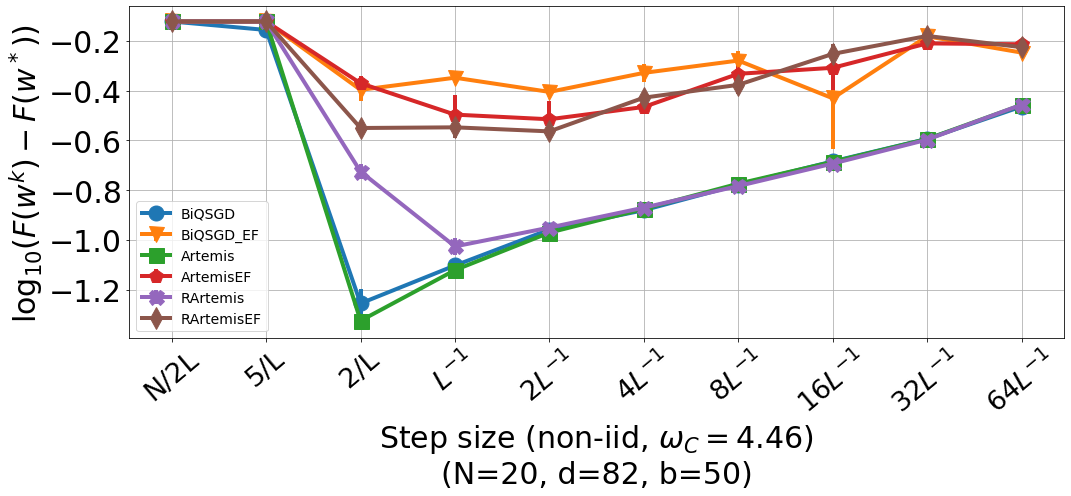

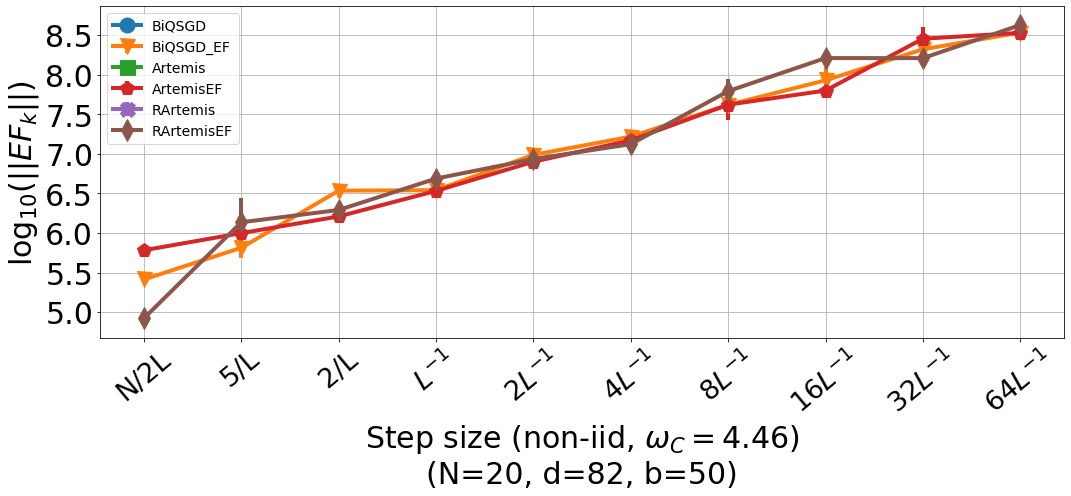

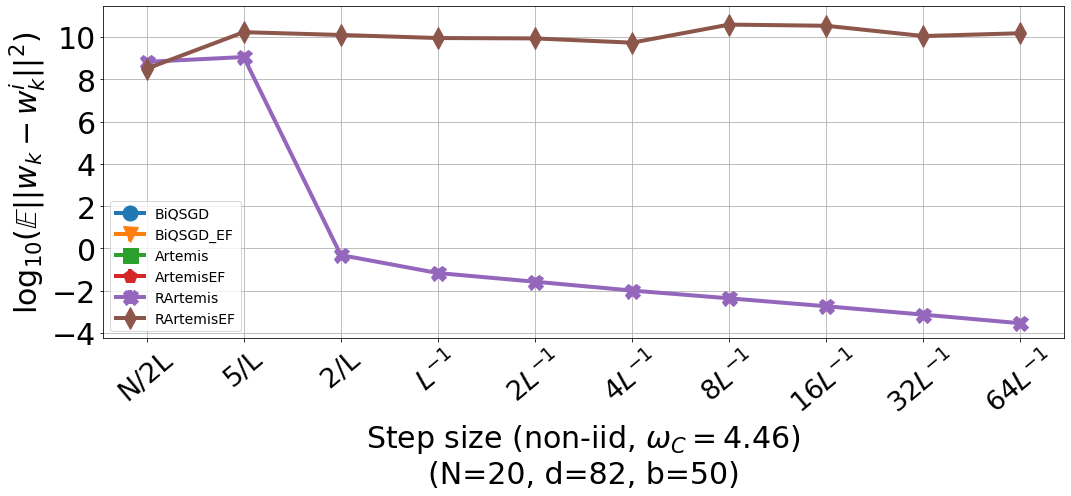

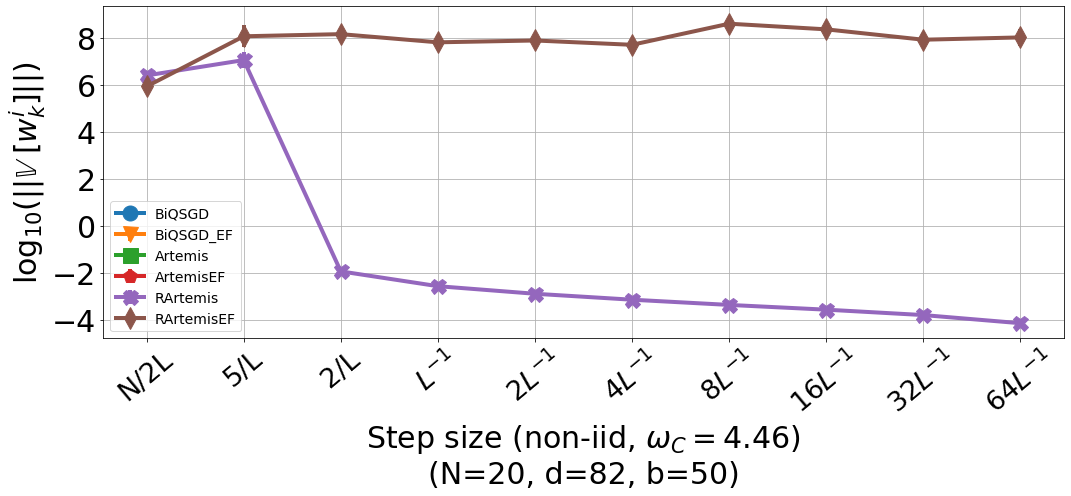

In [12]:
batch_size = 50
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-{1}".format(filename, scenario))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_std(obj), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_step_formula)

plot_error_dist(res.get_error_feedback(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_error_feedback_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_step_formula, ylegends="ef")

plot_error_dist(res.get_distance_to_model(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_distance_to_model_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_step_formula, ylegends="rand_dist")

plot_error_dist(res.get_var_models(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_var_models_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_step_formula, ylegends="rand_var")

## With averaging

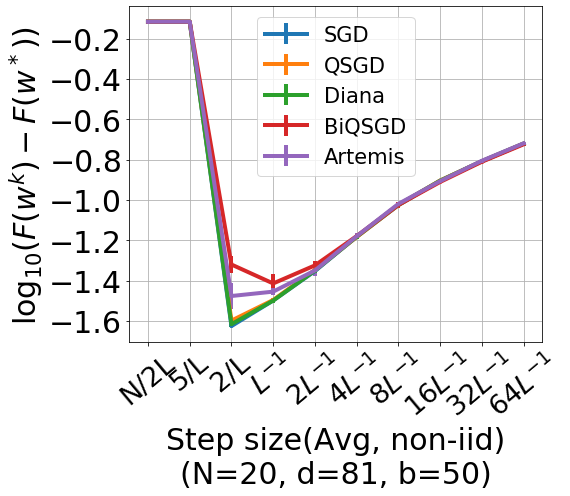

In [9]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-{1}".format(filename, scenario))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Step size(Avg, non-iid)", one_on_two_points=False,
               xlabels=label_step_formula) 

### Display loss for each algorithm

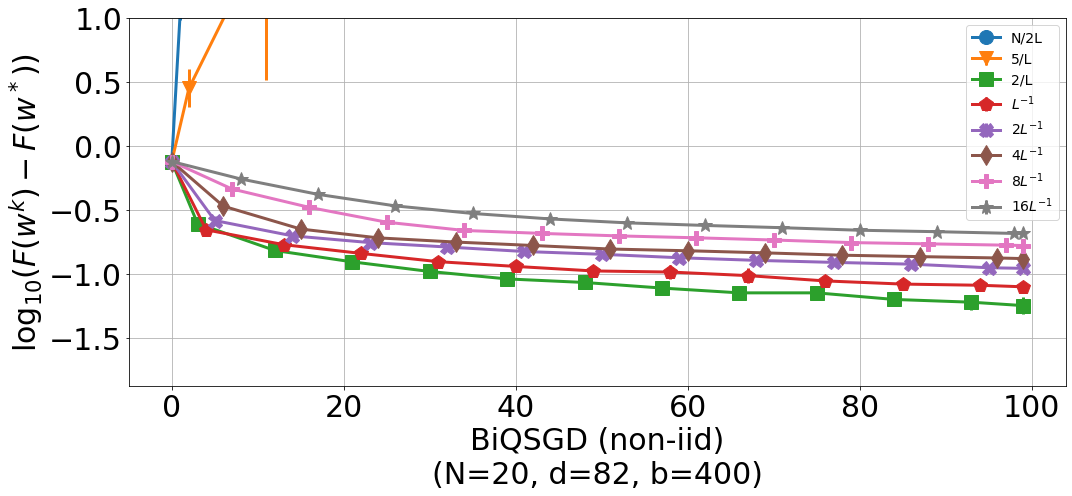

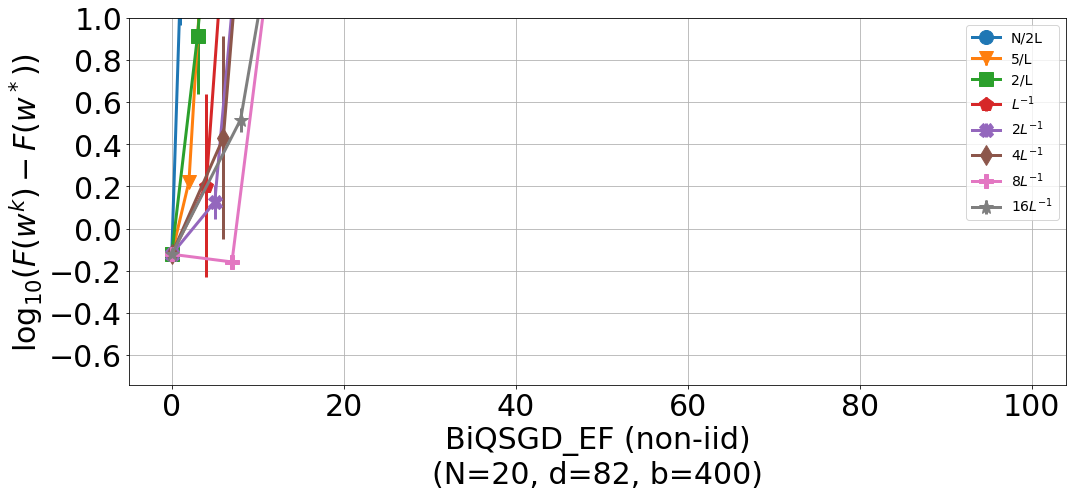

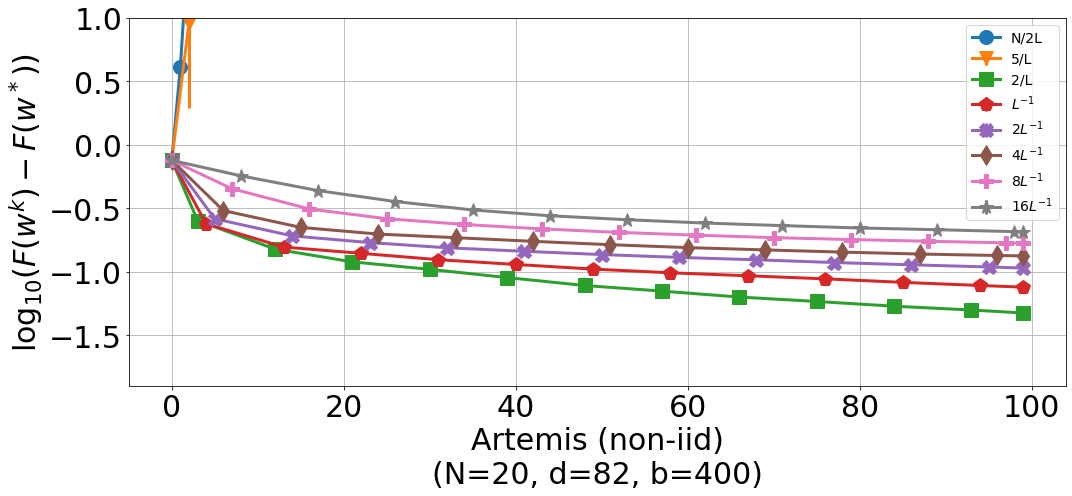

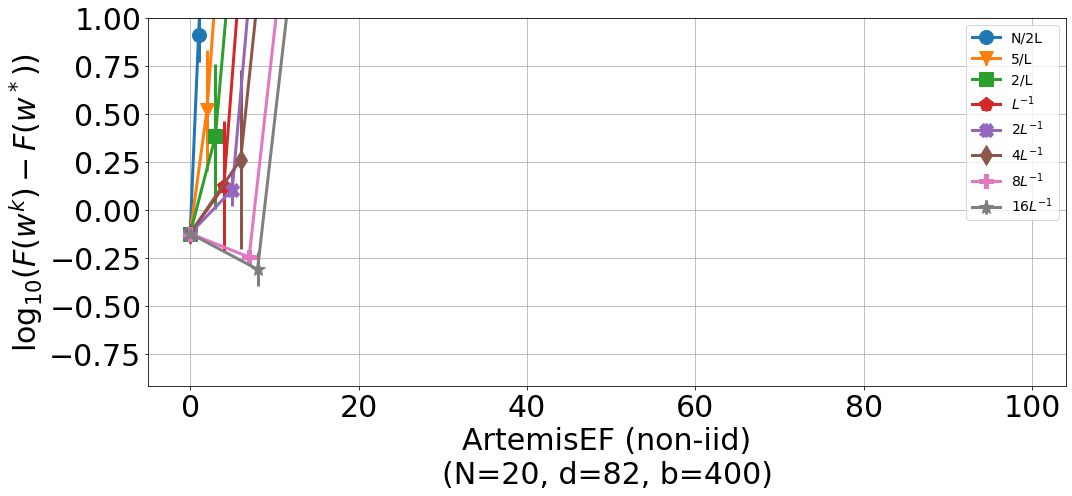

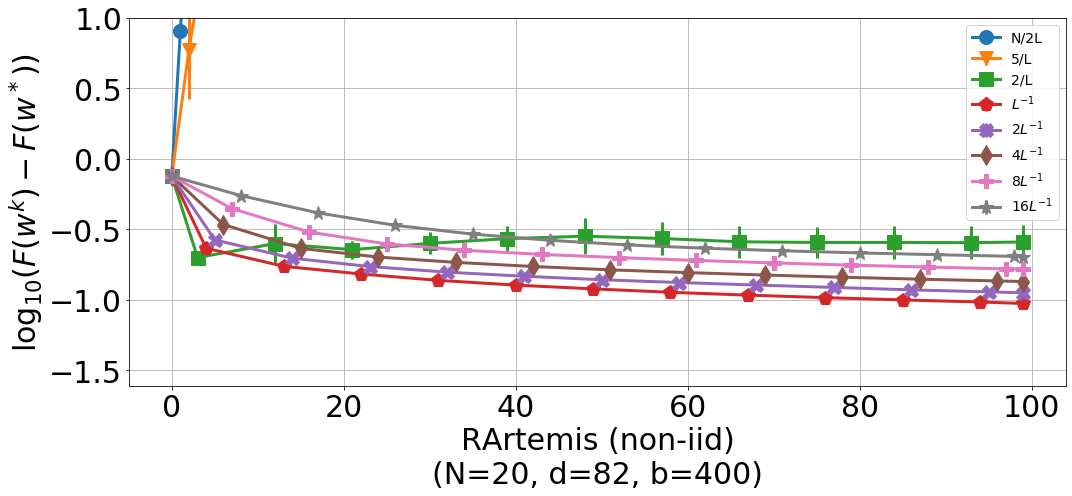

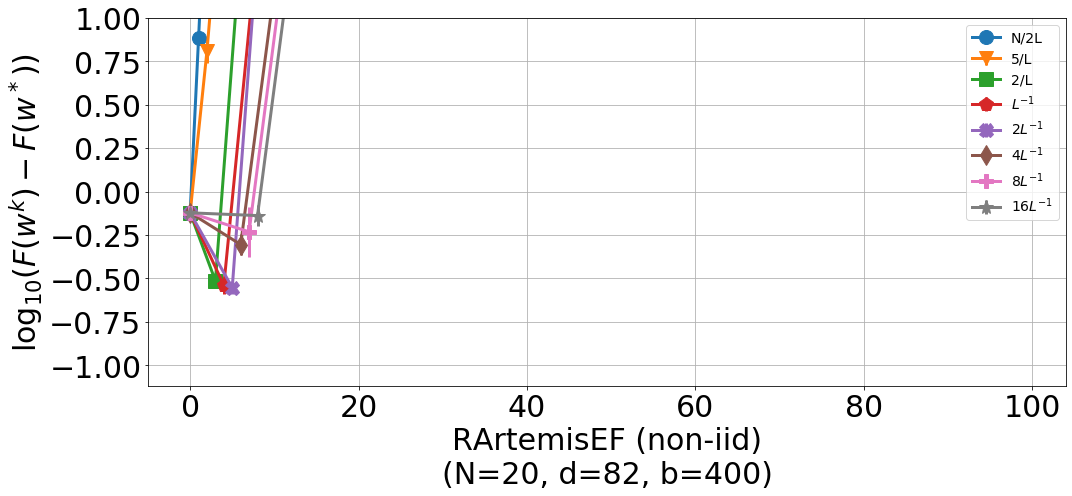

In [21]:
scenario = "step"
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-descent_by_algo_and_{1}".format(filename, scenario))
for algo_name, algo in res.items():
    plot_error_dist(algo.get_loss(obj), algo.names, algo.nb_devices_for_the_run, dim_notebook, 
                    batch_size=batch_size, all_error=algo.get_std(obj), x_legend="{0} (non-iid)".format(algo_name),
                   ylim=True) 


### Display algo with its optimal step size

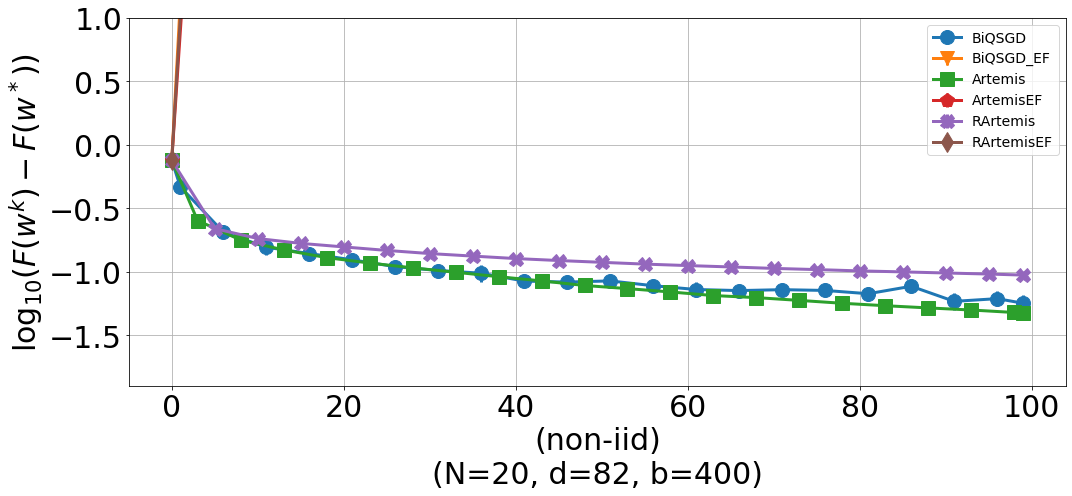

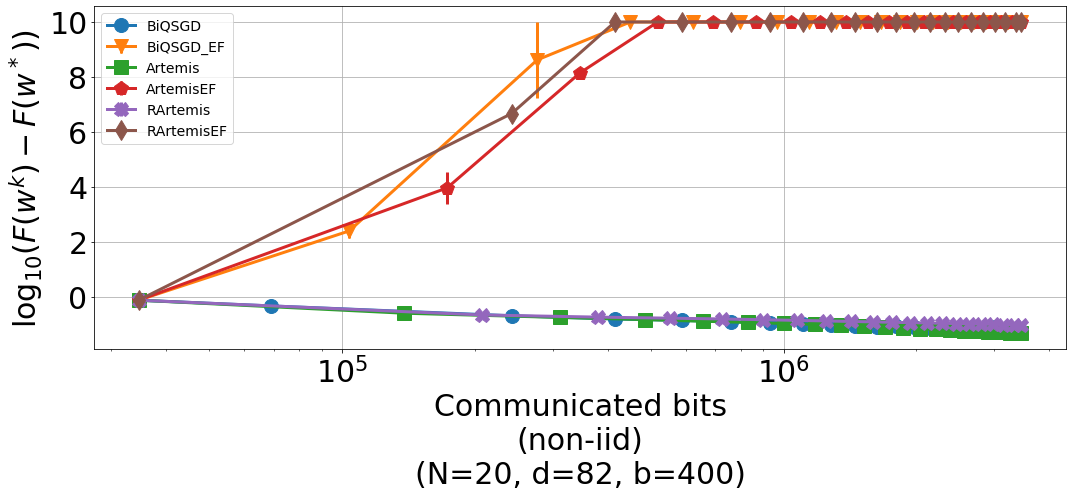

In [23]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-optimal_{1}".format(filename, scenario))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj), batch_size=batch_size,
                x_legend="(non-iid)", ylim=True) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

# Impact of compression

In [30]:
level_spars = 8
level_quantiz = 3

scenario="compression"

def deux_L(it, L, omega, N): return 2 / L

values_compression = [SQuantization(0, dim_notebook),
                      TopKSparsification(level_spars, dim_notebook),
                      TopKSparsification(2*level_spars, dim_notebook),
                      RandomSparsification(level_spars, dim_notebook, biased=True),
                      RandomSparsification(2*level_spars, dim_notebook, biased=True),
                      RandomSparsification(level_spars, dim_notebook, biased=False),
                      RandomSparsification(2*level_spars, dim_notebook, biased=False),
                      RandomSparsification(42, dim_notebook, biased=False),
                      SQuantization(level_quantiz, dim_notebook),
                      SQuantization(2*level_quantiz, dim_notebook)
                     ]

label_compression = ["SGD"] + [value.get_name() + "\n" + str(value.omega_c)[:4] for value in values_compression[1:]]

print(label_compression)

['SGD', 'Topk\n0.09', 'Topk\n0.19', 'RdkBsd\n0.90', 'RdkBsd\n0.80', 'Rdk\n9.25', 'Rdk\n4.12', 'Rdk\n0.95', 'Qtzd\n3.01', 'Qtzd\n1.50']


In [31]:
%%time
batch_size=50

run_for_different_scenarios(cost_models, ARTEMIS_LIKE_ALGO[1:], values_compression, label_compression, filename, 
                            batch_size, stochastic=False, step_formula=deux_L, scenario=scenario)

100%|██████████| 6/6 [14:20<00:00, 143.43s/it]


CPU times: user 56min 20s, sys: 38.9 s, total: 56min 59s
Wall time: 14min 22s


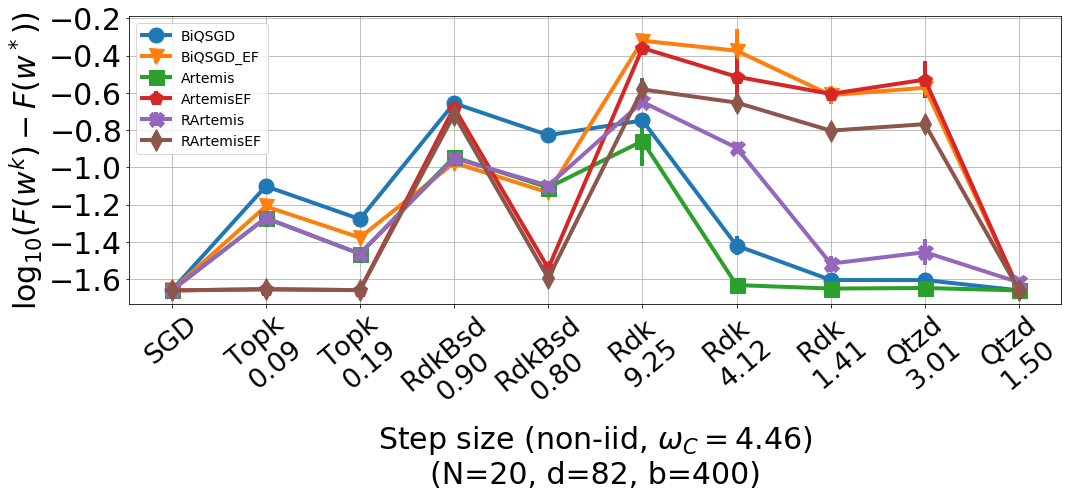

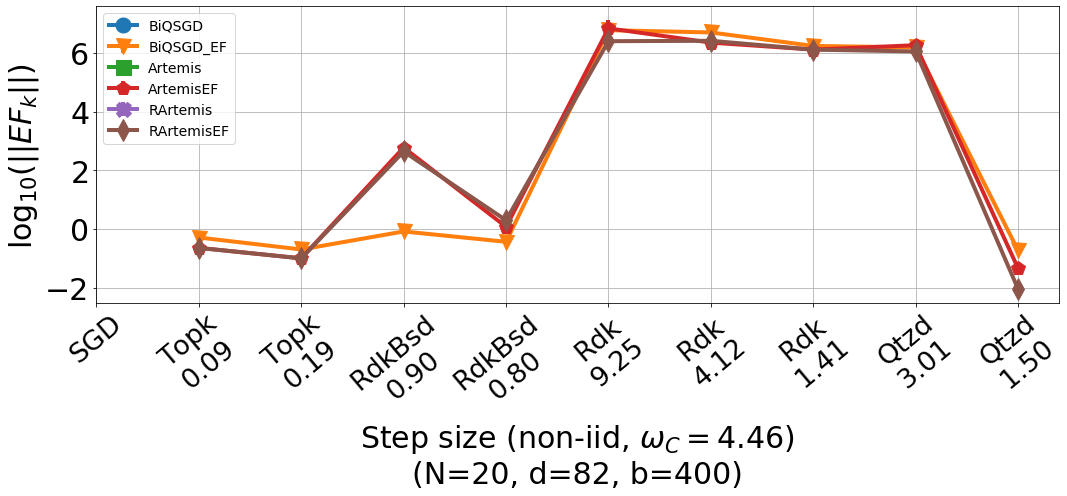

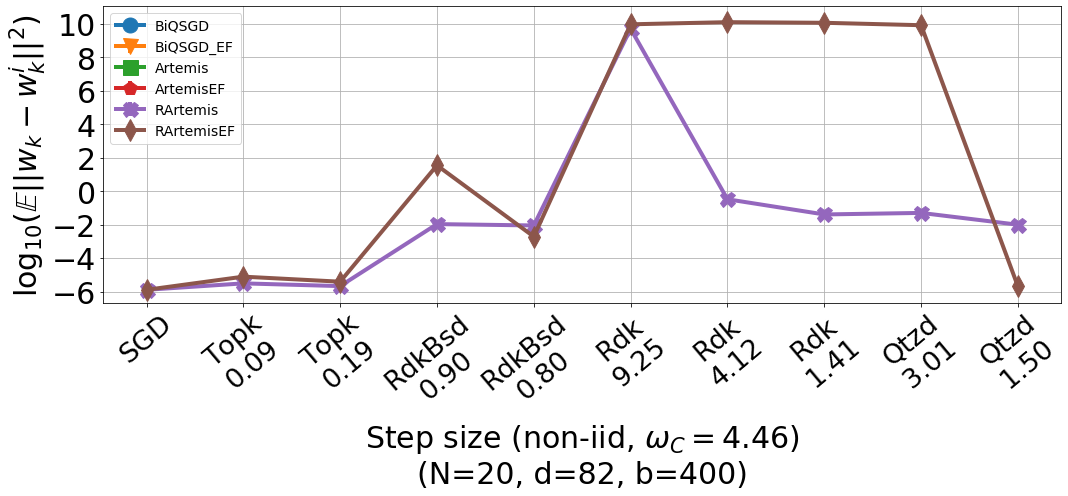

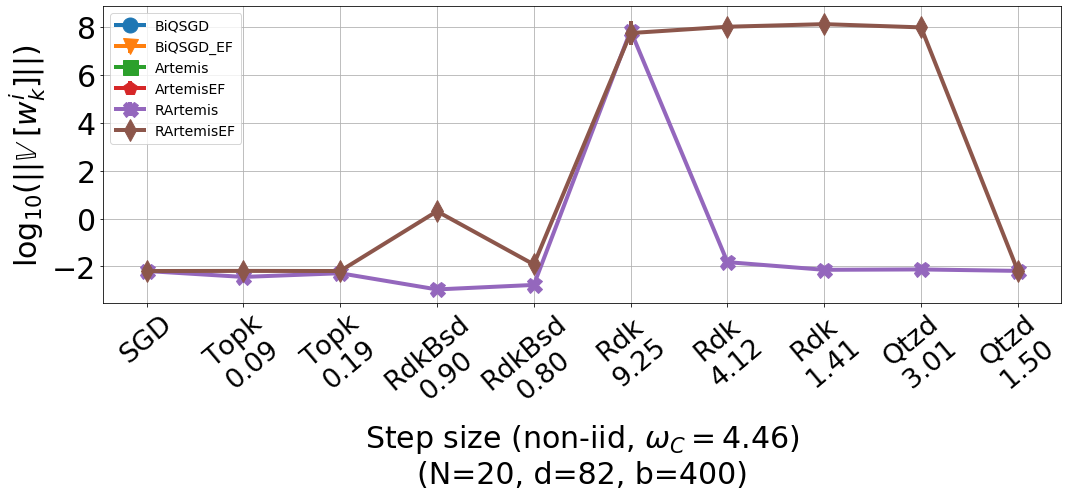

In [17]:
batch_size = 400
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-{1}".format(filename, scenario))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_std(obj), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_compression)

plot_error_dist(res.get_error_feedback(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_error_feedback_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_compression, ylegends="ef")

plot_error_dist(res.get_distance_to_model(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_distance_to_model_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_compression, ylegends="rand_dist")

plot_error_dist(res.get_var_models(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_var_models_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_compression, ylegends="rand_var")